# 画像処理入門講座 : OpenCVとPythonで始める画像処理

画像処理とは、特定の効果（例えば、グレースケール画像）をもたらすために画像を加工したり、操作したりすることです。  
また、コンピュータを使って、画像から情報を取り出したりすること（画像内にある円を数えるといったようなこと）も、画像処理です。

画像処理は、コンピュータビジョンとも深く関係しており、これらの境界線はとても曖昧です。しかし、深刻に考える必要はありません。  
ここで学ぼうとしているのは、画像を加工する方法や、これらの方法を使って、いかに画像情報を集めることができるかということです。

この記事では、画像処理の簡単な構成要素について話していきながら、いくつかのコードや、基本的な操作手順を紹介していきます。  
コードは全てPythonで書かれており、強力な画像処理・コンピュータビジョンのライブラリである、OpenCVを使っていきます。

<a id="index"></a>
## <a href="#index">目次</a>
* [構成要素](#component)
* [画像フォーマット](#format)
* [グレースケール](#gray)
* [閾値処理](#thresh)
* [2値化閾値を使ったマスキング](#mask)
* [ぼかし](#blur)
* [輪郭と外接矩形](#contourAndRectangle)
* [輪郭の検出](#contours)
* [外接矩形の検出](#rectangle)

<a id="conponent"></a>
## 構成要素

まずは、インポートから行います。ここでは、cv2、numpy、そして（主に簡単に画像を表示するために）少しだけmatplotlibを使用します。

In [1]:
import cv2, matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<a id="format"></a>
## 画像フォーマット

まず、現在表示されている画像のフォーマットを知るために、画像を読み込む必要があります。OpenCVでは、画像は3次元のNumPy配列で表されています。  
1つ1つの画像は、ピクセルの行列で構成されており、各ピクセルはその色を表す値の配列によって表現されています。

この画像の場合の配列は、以下のようになります。

In [3]:
# read an image
img = cv2.imread('images/noguchi02.jpg')

# show image format (basically a 3-d array of pixel color info, in BGR format)
print(img)

[[[ 72  99 143]
  [ 76 103 147]
  [ 78 106 147]
  ..., 
  [159 186 207]
  [160 187 213]
  [157 187 212]]

 [[ 74 101 145]
  [ 77 104 148]
  [ 77 105 146]
  ..., 
  [160 187 208]
  [158 186 210]
  [153 183 208]]

 [[ 76 103 147]
  [ 77 104 148]
  [ 76 104 145]
  ..., 
  [157 181 203]
  [160 188 212]
  [158 186 210]]

 ..., 
 [[ 39  78 130]
  [ 39  78 130]
  [ 40  79 131]
  ..., 
  [193 210 223]
  [195 212 225]
  [197 214 227]]

 [[ 32  71 123]
  [ 32  71 123]
  [ 32  71 123]
  ..., 
  [198 215 228]
  [200 217 230]
  [200 217 230]]

 [[ 39  78 130]
  [ 39  78 130]
  [ 39  78 130]
  ..., 
  [199 216 229]
  [200 217 230]
  [201 218 231]]]


[72 99 143]といった数値は、それぞれ1つのピクセルにおける青、緑、赤（BGR）の3色の値を表しています。  
ちなみに、**OpenCVでは、画像はBGRフォーマットで読み込まれる**初期設定となっていますが、Matplotlibの場合はRGBで読み込まれます。  
Matplotlibで画像を表示させるために、BGRフォーマットをRGBに変換しなくてはなりません。

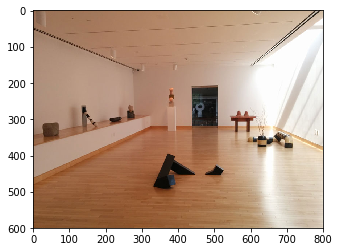

In [10]:
# convert image to RGB color for matplotlib
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# show image with matplotlib
plt.imshow(img)

# 赤、緑、青(RGB)

デジタルの世界では、色は、RBGカラーモデルを使って表現されるのが一般的です。  
このカラーモデルに従って、赤や緑、青の光が様々な形で合わさることで、可視スペクトル上に幅広い色を表現するのです。  
各色はチャンネルと呼ばれており、ペンキの色を混ぜて出来る色とは少し異なります。  

以下がRGBカラーモデルでの発色です。

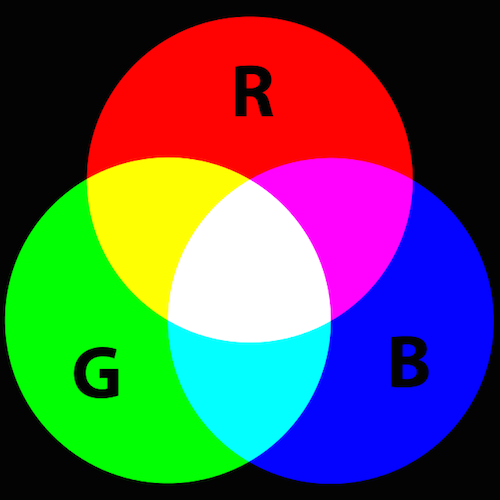

    ・赤 + 緑 = 黄
    ・青 + 緑 = 青緑(シアン)
    ・赤 + 青 = 赤紫(マゼンタ)
    ・赤 + 青 + 緑 = 白
    
ほとんどのシステムでは、RGB値は0から255の領域で表現されるようになっています。数値が高ければ高いほど、その色チャンネルの明度は高くなります。例えば、[255, 51, 0]は赤みがかった色だと推測することができます。  
なぜなら、Rチャンネルの数値が最高値だからです。また[51, 102, 0]が、緑がかった色と推測できるのは、Gチャンネルの数値が最高値だからです。

## 色相、彩度、明度（HSV）

RGBの他に役立つカラーモデルが、HSVカラーモデルです。  
赤や緑、青の色度で色を表現する代わりに、色相（虹色のカラーチャートのどの領域に位置するか）、彩度（色の「鮮やかさ」）、そして明度（明るさとも言い、どの程度の光が取り入れられているか）で表現されます。

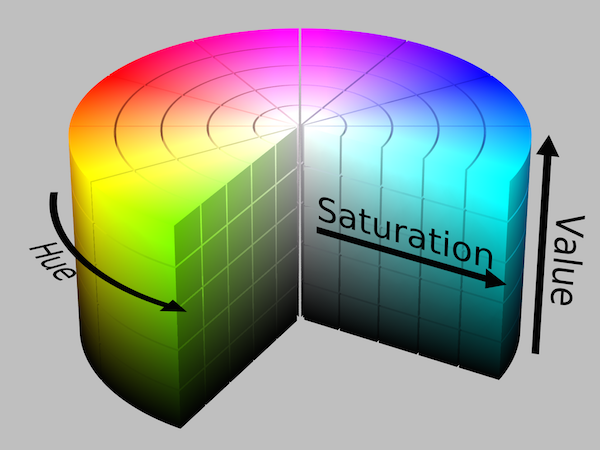

<a id="gray"></a>
## グレースケール

最も暗い色（黒）を表す0、最も明るい色（白）を表す255といった、ピクセルの明るさを表現する256階調のスケールで、  
1つの色チャンネルしか持っていないのが、グレースケール画像です。

画像をグレースケールに変換すると、以下のような2次元の配列になります。

In [7]:
# convert image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# grayscale image represented as a 2-d array
print(gray_img)

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


階調を変更することで、どのように色が変化するのか、カラーピッカーを使って遊んでみるとよいでしょう。
特に、HSVチャンネルの1つを変更した時のRGB値の変化を見るのは、面白いと思います。

### 演習：

ここで学んだことから、画像の平均色を割り出すことができます！
赤、緑、青の各チャンネルの平均値を割り出せば、ピクセルの色の平均値であるRGB値が求められます。
では、np.average()を使ってこのRGB値を割り出した例を見ていきましょう。

In [12]:
# find average per row, assuming image is already in the RGB format.
# np.average() takes in an axis argument which finds the average across that axis.
average_color_per_row = np.average(img, axis=0)

# find average across average per row
average_color = np.average(average_color_per_row, axis=0)

# convert back to uint8
average_color = np.uint8(average_color)
print(average_color)

[179 146 123]


Matpotlbに色を表示するために、このRGB値が追加された100 x 100ピクセルの小さな画像を作成する必要があります。

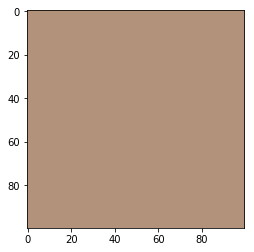

In [13]:
# create 100 x 100 pixel image with average color value
average_color_img = np.array([[average_color]*100]*100, np.uint8)

plt.imshow(average_color_img)

## セグメンテーション

画像情報を集める際、まず、興味のある特徴ごとに分割する必要があります。これをセグメンテーションと呼びます。  
画像セグメンテーションは、分析を容易にすることを目的に、意味を持たせるために画像を部分ごとに表示する処理のことです2。

<a id="thresh"></a>
### 閾値処理

画像セグメンテーションの一番簡単な方法は、閾値処理です。  
基本的な考え方は、ピクセルのチャンネル値が閾値を超えた場合は、画像の各ピクセルを白いピクセルに、  
それ以外は、黒いピクセルに置き換えるという考えです。  

通常は、画像を2値画像、つまりシングルチャンネル画像に変換します。グレースケール画像は、シングルチャンネル画像の一例です。

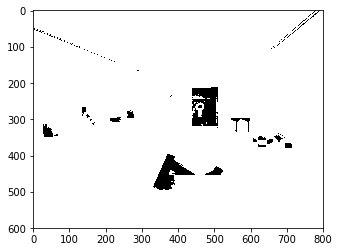

In [25]:
# threshold for image, with threshold 60
_, threshold_img = cv2.threshold(gray_img, 60, 255, cv2.THRESH_BINARY)

# show image
threshold_img = cv2.cvtColor(threshold_img, cv2.COLOR_GRAY2RGB)
plt.imshow(threshold_img)

こうすると、明度の異なる部分を選ぶのが簡単になります。また、**グレースケールではない画像にも利用できます。**  
更に、色チャンネルを使って画像をセグメント分けすることも可能です。色の閾値処理はHSVで最も効果的です。  
HSVの色相チャンネルについて先ほど説明しましたが、赤から緑、緑から青、青から赤紫と移っていくスケールのどこにピクセルの色はあるのでしょうか？

閾値より低い値を探さなくても、cv2.inRange()を使えば、一定の色相の領域内に納まる部分を画像から見つけることができます。

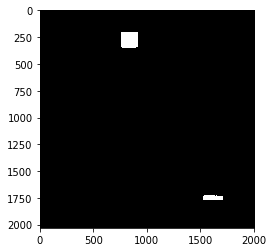

In [32]:
# open new Mondrian Piet painting photo
piet = cv2.imread('images/piet.png')
piet_hsv = cv2.cvtColor(piet, cv2.COLOR_BGR2HSV)

# threshold for hue channel in blue range
blue_min = np.array([85, 60, 60], np.uint8)
blue_max = np.array([150, 255, 255], np.uint8)
threshold_blue_img = cv2.inRange(piet_hsv, blue_min, blue_max)

threshold_blue_img = cv2.cvtColor(threshold_blue_img, cv2.COLOR_GRAY2RGB)

plt.imshow(threshold_blue_img)

<a id="mask"></a>
## 2値化閾値を使ったマスキング

色を区別できるようになったので、面白いことができます。例えば2値画像をマスクとして使ってみましょう。
マスクとは、ビット演算で使われるゼロとゼロ以外の値の行列のことです。
マスクを使うと、画像を切ったり、画像のある部分を”マスク”で隠したりできます。
マスクは通常、ゼロの行列（消したい部分）と、ゼロ以外の行列（残したい部分）です。

それでは、屋外で撮った景色の画像から空を消したバージョンが欲しいとしましょう。
その場合は、最初に、青い色相の領域に含まれるピクセルを見つけます。そうすると、1枚の画像の中から青い空の部分を区別できるようになるのです。
空以外の部分の画像を取り出すには、bitwise_notを使って値が逆になるようにします。
そうすると青以外の部分を残すマスクができます。マスク上でbitwise_andを使うと、画像の青以外の部分だけが残ります。

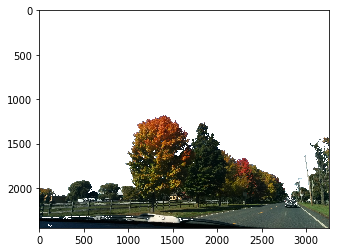

In [33]:
upstate = cv2.imread('images/upstate-ny.jpg')
upstate_hsv = cv2.cvtColor(upstate, cv2.COLOR_BGR2HSV)
plt.imshow(cv2.cvtColor(upstate_hsv, cv2.COLOR_HSV2RGB))

# get mask of pixels that are in blue range
mask_inverse = cv2.inRange(upstate_hsv, blue_min, blue_max)

# inverse mask to get parts that are not blue
mask = cv2.bitwise_not(mask_inverse)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB))

# convert single channel mask back into 3 channels
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)

# perform bitwise and on mask to obtain cut-out image that is not blue
masked_upstate = cv2.bitwise_and(upstate, mask_rgb)

# replace the cut-out parts with white
masked_replace_white = cv2.addWeighted(masked_upstate, 1, \
                                       cv2.cvtColor(mask_inverse, cv2.COLOR_GRAY2RGB), 1, 0)

plt.imshow(cv2.cvtColor(masked_replace_white, cv2.COLOR_BGR2RGB))

<a id="blur"></a>
## ぼかし

写真にノイズが多い場合があります。ノイズが多いと、セグメント分けの邪魔になる、小さい変則的な要素が画像に含まれている場合があるということです。この小さいノイズを取り除くためには、**ガウスぼかし**を使って画像の前処理をする方法がよく使われます。  ぼかしは、明度差の大きい場合や、ピクセル間で激しい変化がある場合に、それらをスムーズにするものだと思ってください。

ガウスぼかしは、画像内の各ピクセルを変換することで効果を出します。これは、画像を正方形（n×n）の**カーネルで畳み込む**ことで行われます。  畳み込みは、周りにあるn×nのピクセルの値に応じて、あるピクセルに操作を適用することだと思ってください。  操作はカーネルによって決められます。  つまり、5×5のカーネルでガウスぼかしを適用すると、全てのピクセルに対し周りの5×5のピクセルが考慮され、平均値を出す計算が行われます。  そうして、新しくぼかされた色がピクセルに与えられるのです。ガウシアンカーネルサイズが大きいほど、画像のぼかしは強くなります。

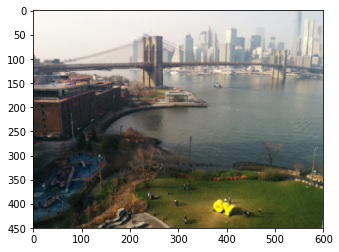

In [36]:
img = cv2.imread('images/oy.jpg')

# gaussian blurring with a 5x5 kernel
img_blur_small = cv2.GaussianBlur(img, (5,5), 0)
plt.imshow(cv2.cvtColor(img_blur_small, cv2.COLOR_BGR2RGB))

5×5のカーネルでぼかしを適用

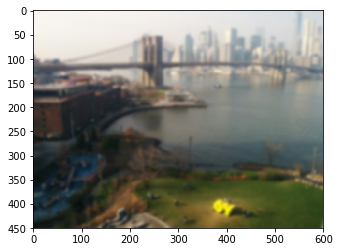

In [37]:
img_blur_large = cv2.GaussianBlur(img, (15,15), 0)
cv2.imwrite('output/oy-gaussian-blur-15.jpg', img_blur_large)
plt.imshow(cv2.cvtColor(img_blur_large, cv2.COLOR_BGR2RGB))

15×15のカーネルでぼかしを適用

ガウスぼかしは、画像にノイズが多く、閾値を適用する前に全ての変則的な要素をスムーズにしたい場合、特に有効です。

結果：

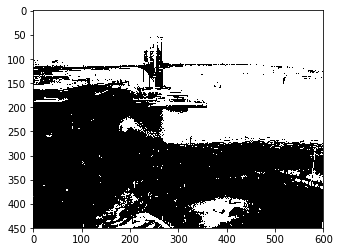

In [38]:
# threshold on regular image
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, threshold_img = cv2.threshold(gray_img, 100, 255, cv2.THRESH_BINARY)
cv2.imwrite('output/oy-no-blur-thresh.jpg', threshold_img)

plt.imshow(cv2.cvtColor(threshold_img, cv2.COLOR_GRAY2RGB))

元の画像に閾値を適用

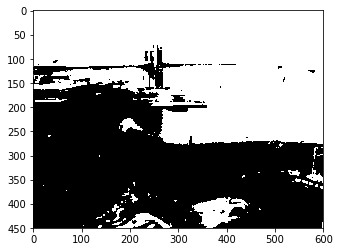

In [39]:
#threshold on blurred image
gray_blur_img = cv2.cvtColor(img_blur_small, cv2.COLOR_BGR2GRAY)
_, threshold_img_blur = cv2.threshold(gray_blur_img, 100, 255, cv2.THRESH_BINARY)
cv2.imwrite('output/oy-gaussian-blur-5-thresh.jpg', threshold_img_blur)
plt.imshow(cv2.cvtColor(threshold_img_blur, cv2.COLOR_GRAY2RGB))

5×5のカーネルでぼかした画像に閾値を適用

上は、ぼかしていない画像に閾値を適用した場合と、5×5のカーネルでぼかした画像に閾値を適用した場合を比較した例です。  ぼかした方が、閾値の適用される塊のラインが明確になり、使いやすくなります。

<a id="contourAndRectangle"></a>
## 輪郭と外接矩形

単純化して2値化したバージョンの画像を作れるようになったので、関心のある特徴だけを区別することができます。
例えば、下の画像から個々のコインを区別するにはどうしたらいいでしょうか。  

このセクションでは、特徴でセグメント分けするために、輪郭と外接矩形を使う方法を説明します。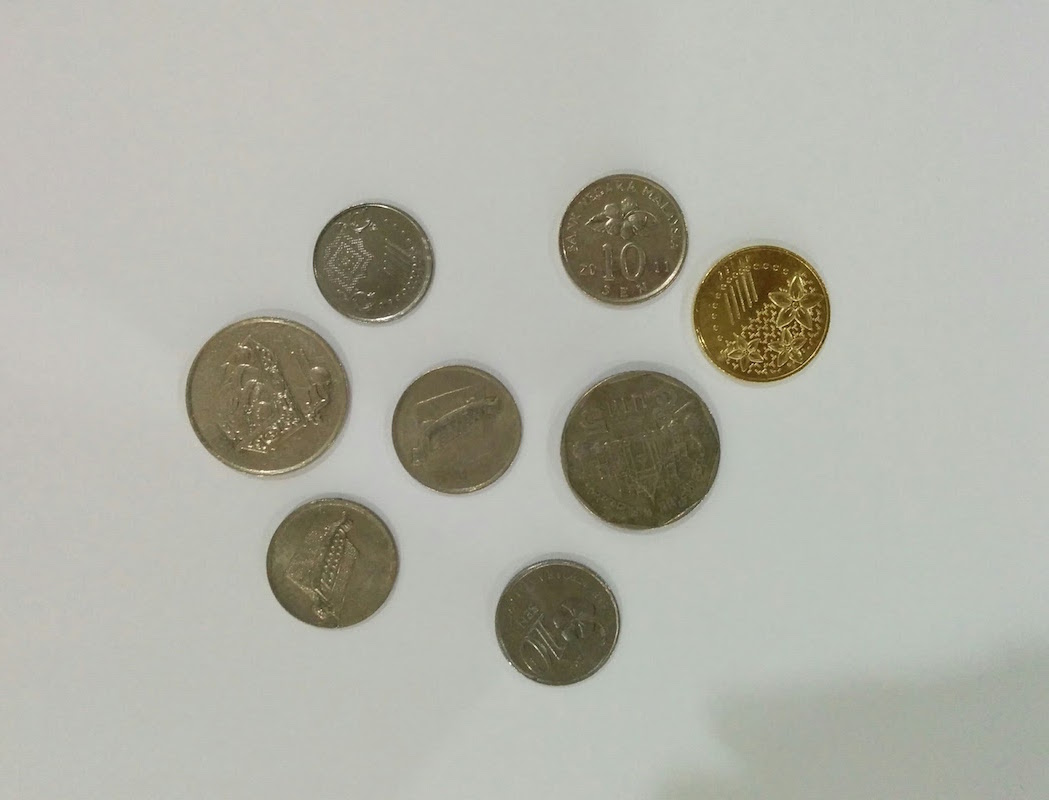

元の画像

## 画像の前処理

まず、画像をグレースケールに変換し、そこにガウスぼかしを適用して単純化とノイズの除去を行います。  
これは前処理の一般的な形式で、画像を扱う際は、大抵の場合、これを最初に行います。それから、前処理を行った画像に2値化閾値処理を適用します。  
コインが明るい場所に置かれているため、閾値は明るい背景部分を関心のある特徴として取り出します。  
ですから、コインを取り出すために2値画像を反転させます。

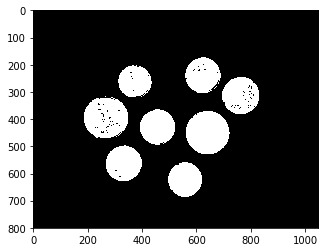

In [41]:
# get binary image and apply Gaussian blur 
coins = cv2.imread('images/coins.jpg')
coins_gray = cv2.cvtColor(coins, cv2.COLOR_BGR2GRAY) # グレースケールに変換
coins_preprocessed = cv2.GaussianBlur(coins_gray, (5, 5), 0) # ガウスぼかしを適用

# get binary image
_, coins_binary = cv2.threshold(coins_preprocessed, 130, 255, cv2.THRESH_BINARY) # 2値化閾値処理

# invert image to get coins
coins_binary = cv2.bitwise_not(coins_binary) # コインを取り出すために2値画像を反転させる
plt.imshow(cv2.cvtColor(coins_binary, cv2.COLOR_GRAY2RGB))

前処理を行った2値画像

<a id="contour"></a>
## 輪郭の検出

輪郭とは、境界線上で同じ色や明度を持つ全ての連続する点をつないだ曲線のことです。  
これは、形状の分析3だけでなく、物体や特徴の検出をする際にも便利です。cv2.findContours()を使うと、それぞれのコインの輪郭を検出できます。  
これをcv2.RETR_EXTERNALフラグの中で関数に渡すと、外郭だけが返されます。つまり、コイン表面の細かいディテールの輪郭までは取り出しません。  

外郭から、それぞれのエリアを検出できるので、コインより小さなものをフィルタで取り除くことができます。  
実際に撮影される写真が完璧ということは、なかなかありません。  
ですから、ノイズや異物を取り除くために、このようなチェックが必要となることがよくあります。  
輪郭エリアを得るためには、cv2.contourArea()を使います。

number of coins: 8


True

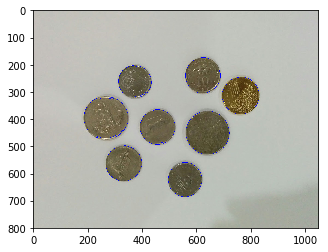

In [50]:
# morph coins by eroding and dilating to remove noise
morph_kernel = np.ones((15,15),np.uint8)
coins_morph = cv2.morphologyEx(coins_binary, cv2.MORPH_CLOSE, morph_kernel)

# plt.imshow(cv2.cvtColor(coins_morph, cv2.COLOR_GRAY2RGB))

# find contours
_, coins_contours, _ = cv2.findContours(coins_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# make copy of image
coins_and_contours = np.copy(coins)

# find contours of large enough area
min_coin_area = 60
large_contours = [cnt for cnt in coins_contours if cv2.contourArea(cnt) > min_coin_area]

# print number of contours
print('number of coins: %d' % len(large_contours))

# draw contours
cv2.drawContours(coins_and_contours, large_contours, -1, (255,0,0))

plt.imshow(cv2.cvtColor(coins_and_contours, cv2.COLOR_BGR2RGB))
cv2.imwrite('coins-contour.jpg', coins_and_contours)


<a id="rectangle"></a>
## 外接矩形の検出

外接矩形とは、輪郭を含むことができる最も小さな長方形のことです。画像から個々のコインをセグメント分けするのに使うことができます。  
cv2.boundingRect()メソッドでは、長方形の左上の角のx座標とy座標、及びに幅と高さの値を外接矩形として返すことを覚えておいてください。  
また、8枚のコインを個別に取り出すために、外接矩形を使うこともできます。

True

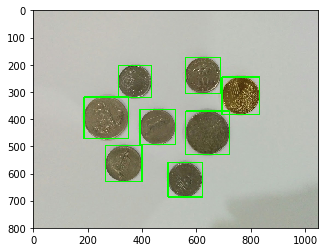

In [53]:
# create copy of image to draw bounding boxes
bounding_img = np.copy(coins)

# for each contour find bounding box and draw rectangle
for contour in large_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(bounding_img, (x, y), (x + w, y + h), (0, 255, 0), 3)
    
plt.imshow(cv2.cvtColor(bounding_img, cv2.COLOR_BGR2RGB))
cv2.imwrite('coins-bounding.jpg', bounding_img)

# 抽出した輪郭ぴったりに線を描画

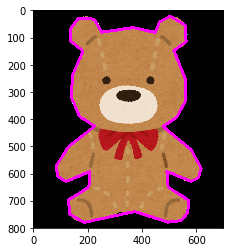

In [3]:
img = cv2.imread('nuigurumi_bear.png', -1)

if img is None:
    sys.exit()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# binarize image
retval, bw = cv2.threshold(gray, 255, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#  Find Contours
imgEdge,contours,hierarchy = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

contours.sort(key=cv2.contourArea, reverse=True)
        
if len(contours[0]) > 0:
    contour = contours[0]

    # 輪郭の近似
    epsilon = cv2.arcLength(contour,True)
    approx = cv2.approxPolyDP(contour,
                              0.003*epsilon,  # 近似の具合
                              True)
    cv2.drawContours(img, [approx], -1, (255, 0, 255), 10)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()